In [1]:
import json
import sys
import numpy as np
from numpy import log, exp, pi
import pandas as pd
import scipy
import scipy.stats as stats
import random
from scipy.stats import gaussian_kde, loguniform
from math import lgamma
from glob import glob
import os
#import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

path = '/Users/chris/Desktop/sculpting/'

In [2]:
berger_kepler = pd.read_csv(path+'berger_kepler_stellar17.csv') # crossmatched with Gaia via Bedell
print(len(berger_kepler))
print(berger_kepler.head())

19969
    kepid           tm_designation  teff  teff_err1  teff_err2   logg  \
0  757280  2MASS J19242289+3633538  6543      162.0     -194.0  4.082   
1  892667  2MASS J19243045+3637186  6609      159.0     -227.0  4.105   
2  892678  2MASS J19243108+3638316  6137      167.0     -186.0  3.936   
3  892713  2MASS J19243353+3637220  6106      186.0     -186.0  3.854   
4  892828  2MASS J19243904+3637166  6691      188.0     -235.0  4.134   

   logg_err1  logg_err2  feh_x  feh_err1  ...  parallax  parallax_err  feh_y  \
0      0.258     -0.172  -0.24      0.25  ...    1.2137        0.0220    NaN   
1      0.246     -0.164  -0.26      0.25  ...    0.8512        0.0154    NaN   
2      0.428     -0.143  -0.26      0.30  ...    1.0236        0.0259    NaN   
3      0.496     -0.124  -0.24      0.30  ...    0.9602        0.0231    NaN   
4      0.209     -0.171  -0.26      0.25  ...    0.9660        0.0143    NaN   

   feh_err    RUWE  num_gaia_companions  Kmag_final_prov  evstate      log

/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (138) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# transit multiplicity from Kepler/Gaia Berger et al 2020, plus Bedell, plus Exoplanet Archive
# see isolate_with_bedell.ipynb
pnum = pd.read_csv(path+'pnum_plus_cands.csv')
print(len(pnum))
pnum = pnum.drop_duplicates(['kepid'])
print(len(pnum))
k = pnum.koi_count.value_counts() 
k = pd.Series([len(berger_kepler)-np.sum(k), 244, 51, 12, 8, 1]) 
print(k)

408
316
0    19653
1      244
2       51
3       12
4        8
5        1
dtype: int64


In [4]:
# redo ms because I forgot that I rounded to single decimal beforehand
ms_corrected = []
ms_corrected_for_plotting = []
for gi_m in range(11):
    for gi_b in range(11):
        ms = -1e-9*np.logspace(8,10,11)[gi_m]
        ms_corrected.append(ms)
        ms_for_plotting = np.log10(np.logspace(8,10,11))[gi_m]
        ms_corrected_for_plotting.append(ms_for_plotting)
print(ms_corrected)
print(ms_corrected_for_plotting)

[-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944

In [14]:
import csv
from ast import literal_eval

with open('simulations_w_cutoff.csv','r') as csvfile: # simulations_w_logslope.csv
    read_csv = csv.reader(csvfile, delimiter='\t')
    read_csv=list(read_csv)

df = pd.DataFrame(read_csv[1:], columns=read_csv[0])
df.lams = df.lams.apply(literal_eval) # convert back from string to list of floats
print(df.columns, df)
df.logLs = df.logLs.apply(literal_eval) # convert back from string to list of floats
df.bs = df.bs.apply(literal_eval)
#df.ms = df.ms.apply(literal_eval)
#df.ms = ms_corrected
df.intact_fracs = df.intact_fracs.apply(literal_eval)
print(ms_corrected)

Index(['﻿ms', 'bs', 'cutoffs', 'intact_fracs', 'logLs', 'lams',
       'geometric_lams', 'geometric_logLs'],
      dtype='object')        ﻿ms   bs        cutoffs  \
0     -2.0  0.0  10000000000.0   
1     -2.0  0.1  10000000000.0   
2     -2.0  0.2  10000000000.0   
3     -2.0  0.3  10000000000.0   
4     -2.0  0.4  10000000000.0   
...    ...  ...            ...   
1205   0.0  0.6   2511886431.5   
1206   0.0  0.7   2511886431.5   
1207   0.0  0.8   2511886431.5   
1208   0.0  0.9   2511886431.5   
1209   0.0  1.0   2511886431.5   

                                           intact_fracs  \
0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4     [0.0001001552406229656, 0.0, 5.00776203114828e...   
...                                                 ...   
1205  [0.5975261655566128, 0.600981521358105, 0

In [17]:
def better_loglike(lam, k):
    """
    Calculate Poisson log likelihood
    Changed 0 handling from simulate.py to reflect https://www.aanda.org/articles/aa/pdf/2009/16/aa8472-07.pdf
    """

    logL = []
    #print(lam)
    for i in range(len(lam)):
        if lam[i]==0:    
            term3 = -lgamma(k[i]+1)
            term2 = -lam[i]
            term1 = 0
            logL.append(term1+term2+term3)
        else:
            term3 = -lgamma(k[i]+1)
            term2 = -lam[i]
            term1 = k[i]*np.log(lam[i])
            logL.append(term1+term2+term3)

    return np.sum(logL)

In [15]:
### re-introduce nonzero-bin transit multiplicities
df_lams_nonzero = []
for x in df.lams:
    df_lams_nonzero.append([y[1:] for y in x])
df['lams_nonzero'] = df_lams_nonzero

In [18]:
fixed_logLs_nonzero = []
for x in df.lams_nonzero:
    temp_fixed_logLs_nonzero = []
    for y in x:
        #print(y, k[1:])
        temp_fixed_logLs_nonzero.append(better_loglike(y, k[1:].reset_index()[0]))
    fixed_logLs_nonzero.append(temp_fixed_logLs_nonzero)
df['logLs_nonzero'] = fixed_logLs_nonzero

In [19]:
df

,﻿ms,bs,cutoffs,intact_fracs,logLs,lams,geometric_lams,geometric_logLs,lams_nonzero,logLs_nonzero
0,-2.0,0.0,10000000000.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-232.94398685479956, -255.7688359814508, -218...","[[19235.0, 679.0, 55.0, 0.0, 0.0, 0.0], [19216...","[[18655.0, 1182.0, 132.0, 0.0, 0.0, 0.0], [186...","[-654.7579933457946, -653.7593986394355, -650....","[[679.0, 55.0, 0.0, 0.0, 0.0], [712.0, 41.0, 0...","[-222.57277355898242, -244.9751353437184, -208..."
1,-2.0,0.1,10000000000.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-247.85433943809193, -258.643480677938, -251....","[[19240.0, 696.0, 33.0, 0.0, 0.0, 0.0], [19208...","[[18676.0, 1175.0, 118.0, 0.0, 0.0, 0.0], [186...","[-639.814270498297, -672.9372520277183, -693.5...","[[696.0, 33.0, 0.0, 0.0, 0.0], [717.0, 44.0, 0...","[-237.5911183737714, -247.66614469402157, -240..."
2,-2.0,0.2,10000000000.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-242.0227742829308, -238.020700602357, -218.6...","[[19226.0, 693.0, 50.0, 0.0, 0.0, 0.0], [19233...","[[18628.0, 1214.0, 127.0, 0.0, 0.0, 0.0], [186...","[-678.6744758777969, -678.3822822863001, -619....","[[693.0, 50.0, 0.0, 0.0, 0.0], [687.0, 49.0, 0...","[-231.45382805098842, -227.6059186242651, -208..."
3,-2.0,0.3,10000000000.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-212.05481357154127, -250.63750983160546, -25...","[[19267.0, 647.0, 55.0, 0.0, 0.0, 0.0], [19221...","[[18656.0, 1189.0, 124.0, 0.0, 0.0, 0.0], [186...","[-655.4523155765595, -685.7174264392513, -664....","[[647.0, 55.0, 0.0, 0.0, 0.0], [705.0, 43.0, 0...","[-202.3518328250844, -239.95685134359493, -248..."
4,-2.0,0.4,10000000000.0,"[0.0001001552406229656, 0.0, 5.00776203114828e...","[-246.8078621141105, -239.60489033682526, -226...","[[19232.0, 698.0, 39.0, 0.0, 0.0, 0.0], [19240...","[[18663.0, 1193.0, 113.0, 0.0, 0.0, 0.0], [186...","[-651.9977107899413, -650.4205871407914, -645....","[[698.0, 39.0, 0.0, 0.0, 0.0], [688.0, 41.0, 0...","[-236.37121610352932, -229.34166927250473, -21..."
...,...,...,...,...,...,...,...,...,...,...
1205,0.0,0.6,2511886431.5,"[0.5975261655566128, 0.600981521358105, 0.6008...","[-541.4903340994379, -562.4048463870154, -541....","[[18735.0, 766.0, 279.0, 108.0, 62.0, 14.0], [...","[[18090.0, 965.0, 396.0, 253.0, 174.0, 71.0], ...","[-1120.710926562313, -1203.516555186355, -1152...","[[766.0, 279.0, 108.0, 62.0, 14.0], [764.0, 26...","[-513.4963637050997, -533.6695856036698, -514...."
1206,0.0,0.7,2511886431.5,"[0.6994842005107917, 0.6992838900295458, 0.703...","[-651.4265229609039, -579.9847399379678, -581....","[[18615.0, 790.0, 325.0, 150.0, 68.0, 20.0], [...","[[17947.0, 952.0, 439.0, 298.0, 208.0, 105.0],...","[-1270.952059730075, -1174.0077973493983, -121...","[[790.0, 325.0, 150.0, 68.0, 20.0], [726.0, 29...","[-617.1477806947253, -550.4955704954073, -552...."
1207,0.0,0.8,2511886431.5,"[0.8057489108117583, 0.8044468926836597, 0.797...","[-656.3626336158175, -676.5164727683638, -760....","[[18616.0, 747.0, 319.0, 182.0, 81.0, 18.0], [...","[[17917.0, 886.0, 444.0, 341.0, 230.0, 121.0],...","[-1308.2209997547302, -1353.3640011819427, -14...","[[747.0, 319.0, 182.0, 81.0, 18.0], [742.0, 34...","[-622.1396244755285, -641.2248299545078, -719...."
1208,0.0,0.9,2511886431.5,"[0.8984926636286243, 0.90104662226451, 0.89724...","[-735.6054670787422, -758.5181898556586, -711....","[[18530.0, 761.0, 363.0, 204.0, 80.0, 26.0], [...","[[17842.0, 854.0, 505.0, 356.0, 249.0, 128.0],...","[-1386.8629965196887, -1451.4687488627062, -13...","[[761.0, 363.0, 204.0, 80.0, 26.0], [725.0, 39...","[-696.3814877228584, -718.5628345416737, -674...."


In [22]:
df.cutoffs.unique()

array(['10000000000.0', '630957344.5', '158489319.2', '398107170.6',
       '3981071705.5', '6309573444.8', '251188643.2', '1584893192.5',
       '1000000000.0', '2511886431.5'], dtype=object)

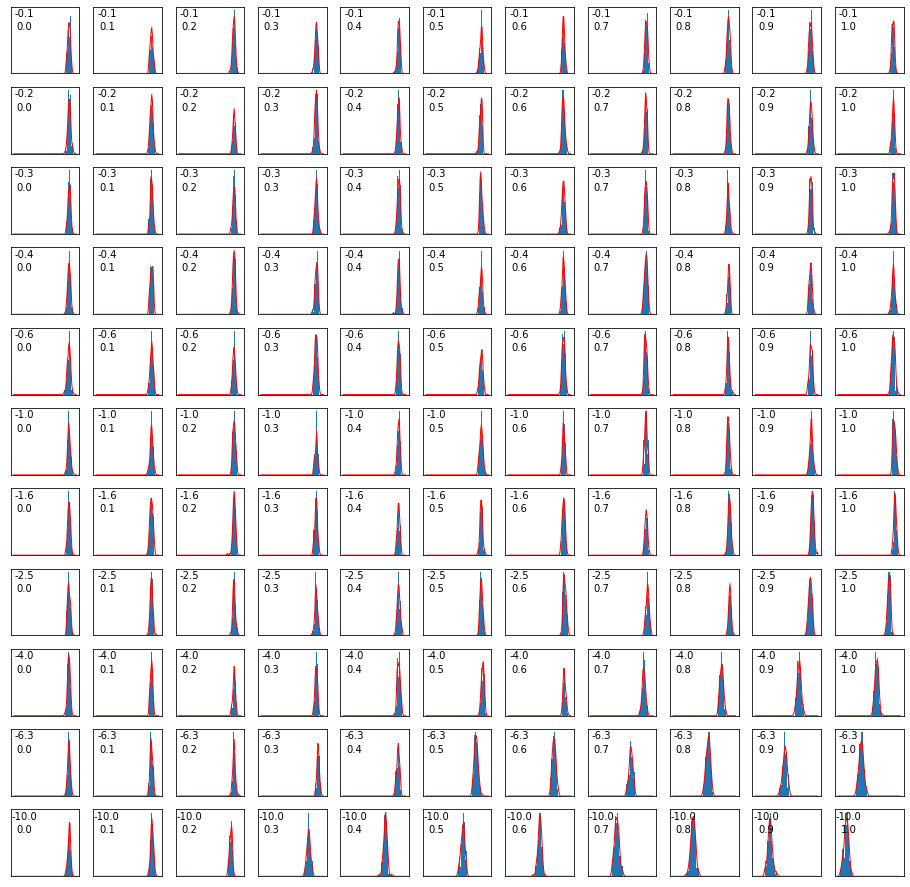

In [21]:
def kde_func(x, x_grid, bandwidth):
    """Kernel Density Estimation with Scipy"""
    kde = gaussian_kde(x) # constant bandwidth so imbalance in sample size doesn't drive distribution
    return kde.evaluate(x_grid)

def prior_grid(cube, ndim, nparams, gi_m, gi_b):
    """
    Each model run will use an evenly spaced (m,b) tuple on a discrete 11x11 grid
    Does that ruin the point of multinest? Is it valid without random sampling? 
    Maybe so, but pymultinest keeps getting stuck, so I need to get a better sense of the logL surface.
    gi_m: grid index on m axis
    gi_b: grid index on b axis
    """
    cube[0] = np.linspace(-1,0,11)[gi_m]
    cube[1] = np.linspace(0,1,11)[gi_b]
    return cube

def generate_rand_from_pdf(pdf, x_grid, n):
    cdf = np.cumsum(pdf) # create cdf
    cdf = cdf / cdf[-1] # normalize cdf
    values = np.random.rand(n) 
    value_bins = np.searchsorted(cdf, values) # return positions in cdf vector where random values should go
    random_from_cdf = x_grid[value_bins] # select x_d positions based on these random positions
    return random_from_cdf

def kde(x, x_grid, bandwidth):
    """Kernel Density Estimation with Scipy"""
    #kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=0)) # ddof=1 means std divisor is N-1 instead of N
    #kde = gaussian_kde(x, bw_method=np.power(len(x), -0.2)) # ddof=1 means std divisor is N-1 instead of N
    kde = gaussian_kde(x, bw_method=0.15) # constant bandwidth so imbalance in sample size doesn't drive distribution
    #print(bandwidth/x.std(ddof=1)) # this is bw used in S/O
    #print(np.power(len(x), -0.2)) # the bw if I use Scott's factor as the bw to multiply with covariance matrix
    return kde.evaluate(x_grid)

plt.figure(figsize=(16,16))
index = 0
ndim = 2
nbins = 10
nparams = 2
draws = 50
logLs = df.logLs_nonzero
lams = df.lams_nonzero
lower = min([min(i) for i in logLs])
upper = max([max(i) for i in logLs])
bs = df.bs
ms = ms_corrected
peak_logLs = []
mean_logLs = []
for gi_m in range(11):
    for gi_b in range(11):
        ax = plt.subplot2grid((11,11), (gi_m,gi_b))
        ax.text(0.2, 0.9, round(ms[index], 1), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.text(0.2, 0.7, bs[index], horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        hist, bins = np.histogram(logLs[index], bins=20)
        
        x_grid = np.linspace(lower, upper, 100)
        kdepdf = kde_func(np.array(logLs[index]), x_grid, bandwidth=0.2) # generate KDE model
        peak_logLs.append(x_grid[np.argmax(kdepdf)])
        mean_logLs.append(np.mean(logLs[index]))
        #random_from_kde = generate_rand_from_pdf(kdepdf, x_grid, draws) # generate random data from KDE distribution
        #print(kdepdf)
        
        bin_midpoints = bins[:-1] + np.diff(bins) / 2 # get positions of bin midpoints
        random_from_cdf = generate_rand_from_pdf(hist, bin_midpoints, draws) # generate random data from histogram
        
        #plt.hist(logLs[index], bins=np.linspace(lower, upper, 20))
        ax.hist(logLs[index], nbins, density=True) # plot histogram of normalized data
        ax.plot(x_grid, kdepdf, color='r', lw=1) # plot KDE over normalized histogram
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        index += 1
        
plt.savefig('logLs.eps', format='eps')
plt.show()

In [28]:
df_slice = df.loc[df.bs == 0.5]
print(df_slice)

       ﻿ms   bs        cutoffs  \
5     -2.0  0.5  10000000000.0   
16    -1.8  0.5  10000000000.0   
27    -1.6  0.5  10000000000.0   
38    -1.4  0.5  10000000000.0   
49    -1.2  0.5  10000000000.0   
...    ...  ...            ...   
1160  -0.8  0.5   2511886431.5   
1171  -0.6  0.5   2511886431.5   
1182  -0.4  0.5   2511886431.5   
1193  -0.2  0.5   2511886431.5   
1204   0.0  0.5   2511886431.5   

                                           intact_fracs  \
5     [0.0, 0.0, 5.00776203114828e-05, 0.0, 0.0, 0.0...   
16    [5.00776203114828e-05, 0.0, 5.00776203114828e-...   
27    [5.00776203114828e-05, 5.00776203114828e-05, 0...   
38    [5.00776203114828e-05, 0.0, 0.0, 0.00010015524...   
49    [5.00776203114828e-05, 5.00776203114828e-05, 5...   
...                                                 ...   
1160  [0.0007010866843607592, 0.000500776203114828, ...   
1171  [0.0034553558014923133, 0.003004657218688968, ...   
1182  [0.031098202213430817, 0.03134859031498823, 0....   
1

ValueError: x and y must be the same size

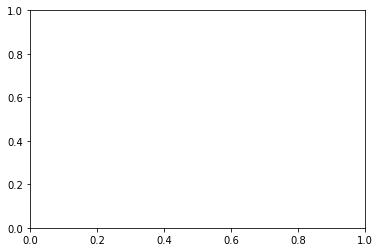

In [27]:
plt.scatter(bs, ms_corrected, c=peak_logLs) # mean_logLs2 for mean instead of peak location of KDE
plt.xlabel('initial P(intact) aka b')
plt.ylabel('dP(intact)/dt aka m [Gyr^-1]')
#plt.gca().invert_yaxis()
plt.yscale('symlog', linthreshy=0.1)
#plt.yscale('symlog', base=10)
#plt.yscale('log')
plt.colorbar()
#plt.tight_layout()
plt.ylim(-0.09, -13) 
plt.show()

In [23]:
df.loc[:, "mean_intact_fracs"] = df.intact_fracs.apply(lambda x: np.mean(x))

In [26]:
len(df.mean_intact_fracs)
len(peak_logLs)

121

ValueError: x and y must be the same size

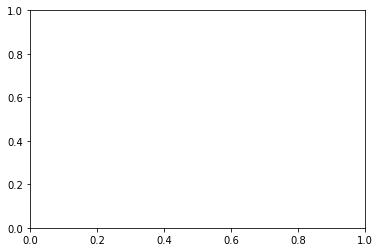

In [24]:
plt.scatter(df.mean_intact_fracs, peak_logLs)
plt.ylabel('peak logLs')
plt.xlabel('intact fraction')
plt.savefig('logLs_v_intacts.eps', format='eps')
plt.show()